In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cyl_ecto_network import CylEctoNetwork
from hydranerv.models.network.neuron import Neuron
from hydranerv.models.network.rpnet.rp_neuron import RPNeuron
from hydranerv.utils import utils
from collections import defaultdict

from hydranerv.models.network.cyl_network import CylNetwork
import time

In [3]:
def plot_train(train):
    plt.figure(figsize=(20,3))
    plt.plot(train)
    plt.show()

In [4]:
def sim_ped_reg(ntwk, zcut, num_pm, conn_scale):
    """simulate peduncle regenration"""
    
    ZCUT = zcut
    NUM = num_pm
    CONN_SCALE = conn_scale
    
    # add CB and RP neurons
    cb_to_add = []
    rp_to_add = []
    loc_cb_to_add = []
    loc_rp_to_add = []

    for i in range(NUM):
        # add cb pacemakers
        phi = np.random.uniform(0, 2 * np.pi)
        z = np.random.uniform(ZCUT-.1, ZCUT)
        loc_cb_to_add.append((phi, z))

        cb_to_add.append(
            Neuron(ntwk.cbnet.dt, ntwk.cbnet.tmax, np.random.uniform(-ntwk.cbnet.wnoise, ntwk.cbnet.wnoise), True, ntwk.cbnet.t_ref)
        )

        # add rp neurons
        phi = np.random.uniform(0, 2 * np.pi)
        z = np.random.uniform(ZCUT-.1, ZCUT)
        loc_rp_to_add.append((phi, z))
        rp_to_add.append(
            RPNeuron(ntwk.rpnet.dt, ntwk.rpnet.tmax, ntwk.rpnet.t_ref)
        )

    # include cb_to_add into the cbnet
    ntwk.cbnet.neurons.extend(cb_to_add)
    ntwk.cbnet.locations.extend(loc_cb_to_add)
    ntwk.cbnet.pacemakers.extend(list(range(ntwk.cbnet.num, ntwk.cbnet.num + NUM)))
    ntwk.cbnet.num += NUM
    ntwk.cbnet.neighbors.extend([[] for _ in range(NUM)])

    # modify pacemakers
    for pm in ntwk.cbnet.pacemakers:
        neuron = ntwk.cbnet.neurons[pm]
        neuron.k_a = 7500
        neuron.k_e = 1000


    # include rp_to_add into the rpnet
    ntwk.rpnet.neurons.extend(rp_to_add)
    ntwk.rpnet.locations.extend(loc_rp_to_add)
    ntwk.rpnet.num += NUM
    ntwk.rpnet.neighbors.extend([[] for _ in range(NUM)])
    
    # make connections

    # cb <-> cb
    for i in range(ntwk.cbnet.num - NUM, ntwk.cbnet.num):

        for j in range(ntwk.cbnet.num - NUM): # downstream neurons

            if ntwk.cbnet.locations[j][1] <= ZCUT:

                dist = utils.cyl_dist((ntwk.cbnet.rho, ntwk.cbnet.locations[i][0], ntwk.cbnet.locations[i][1]),
                                      (ntwk.cbnet.rho, ntwk.cbnet.locations[j][0], ntwk.cbnet.locations[j][1]),
                                      z_scale=.3)

                if np.random.rand() < ntwk.cbnet.conn_prob(dist) * CONN_SCALE:
                        ntwk.cbnet.add_edge((i, j))

        for j in range(i+1, ntwk.cbnet.num): # j in pacemakers

            dist = utils.cyl_dist((ntwk.cbnet.rho, ntwk.cbnet.locations[i][0], ntwk.cbnet.locations[i][1]),
                                  (ntwk.cbnet.rho, ntwk.cbnet.locations[j][0], ntwk.cbnet.locations[j][1]))
            if np.random.rand() < ntwk.cbnet.conn_prob(dist, lambda_d=.3) * CONN_SCALE:
                ntwk.cbnet.add_edge((i, j))

    # rp <-> rp
    for i in range(ntwk.rpnet.num - NUM, ntwk.rpnet.num):

        for j in range(ntwk.rpnet.num - NUM): # downstream neurons

            if ntwk.rpnet.locations[j][1] <= ZCUT:

                dist = utils.cyl_dist((ntwk.rpnet.rho, ntwk.rpnet.locations[i][0], ntwk.rpnet.locations[i][1]),
                                      (ntwk.rpnet.rho, ntwk.rpnet.locations[j][0], ntwk.rpnet.locations[j][1]))

                if np.random.rand() < ntwk.rpnet.conn_prob(dist) * CONN_SCALE:
                        ntwk.rpnet.add_edge((i, j))

        for j in range(i+1, ntwk.rpnet.num): # j in pacemakers

            dist = utils.cyl_dist((ntwk.rpnet.rho, ntwk.rpnet.locations[i][0], ntwk.rpnet.locations[i][1]),
                                  (ntwk.rpnet.rho, ntwk.rpnet.locations[j][0], ntwk.rpnet.locations[j][1]))
            if np.random.rand() < ntwk.rpnet.conn_prob(dist, lambda_d=.3) * CONN_SCALE:
                ntwk.rpnet.add_edge((i, j))
                
    # rp <-> cb
    ntwk.setup()
                
    # reset prev
    ntwk.prev = defaultdict(list)
    # set rp -> cb edges
    ntwk.prev['cb'] = [[] for _ in range(ntwk.cbnet.num)]
    for edge in ntwk.edges['rp_to_cb']:
        if edge:
            ntwk.prev['cb'][edge[0]].append(edge[1])

    # set cb -> rp edges
    ntwk.prev['rp'] = [[] for _ in range(ntwk.rpnet.num)]
    for edge in ntwk.edges['cb_to_rp']:
        if edge:
            ntwk.prev['rp'][edge[0]].append(edge[1])
    
    # cut lines
    ntwk.cut(direction='phi', start=0, end=2*np.pi, otherval=ZCUT)
    
    ntwk.disp_network(edge_type='cb', show_pm=True, upper_bound=ZCUT)
    
    ntwk.run()
    
    # select neurons to plot
    indices_cb_ped = []
    indices_cb_hyp = []
    for i in range(ntwk.cbnet.num):
        if ntwk.cbnet.locations[i][1] < ZCUT:
            indices_cb_ped.append(i)
        else:
            indices_cb_hyp.append(i)

    indices_rp_ped = []
    indices_rp_hyp = []
    for i in range(ntwk.rpnet.num):
        if ntwk.rpnet.locations[i][1] < ZCUT:
            indices_rp_ped.append(i)
        else:
            indices_rp_hyp.append(i)
    
    # ntwk.cbnet.disp(xlim=(350, 800), title='CB net hyp', indices=indices_cb_hyp)
    # ntwk.rpnet.disp(xlim=(350, 800), title='RP net hyp', indices=indices_rp_hyp)
    ntwk.cbnet.disp(xlim=(850, 1300), title='CB net ped', indices=indices_cb_ped)
    ntwk.rpnet.disp(xlim=(850, 1300), title='RP net ped', indices=indices_rp_ped)
    
    plt.figure(figsize=(20,3))
    plt.plot(ntwk.cbnet.neurons[-1].v_train[:])
    plt.plot(ntwk.rpnet.neurons[-1].v_train[:])
    plt.show()

## .6

In [5]:
ntwk = CylEctoNetwork(tmax=1500,
                      num_cb=100,
                      num_rp=100,
                      num_hyp=30,
                      num_ped=30,
                      gc_cb=500,
                      gc_rp=500,
                      pm_cb=list(range(30)),
                      tau_inh_cb=5,
                      tau_inh_rp=5,
                      a_inh_cb=40,
                      a_inh_rp=40,
                      lambda_d=(.25, .25),
                      t_ref=.1,
                      seed_cb=123,
                      seed_rp=5)

# modify pacemakers
for pm in ntwk.cbnet.pacemakers:
    neuron = ntwk.cbnet.neurons[pm]
    neuron.k_a = 7500
    neuron.k_e = 1000

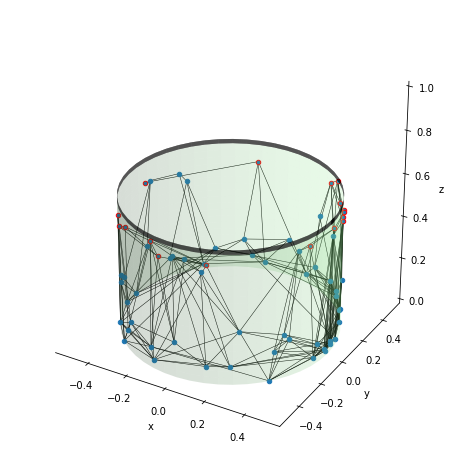

100%|████████████████████████████████████| 149999/149999 [07:09<00:00, 349.01it/s]


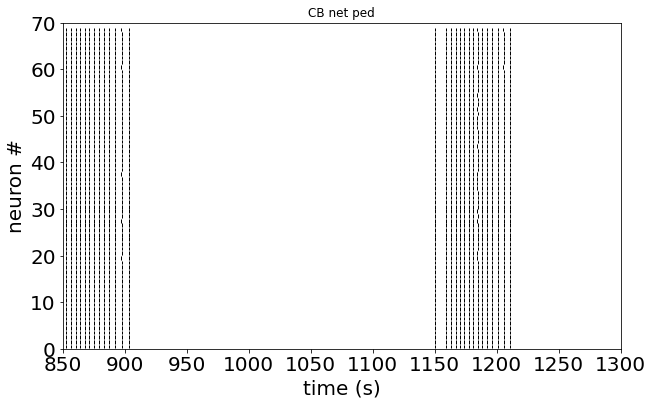

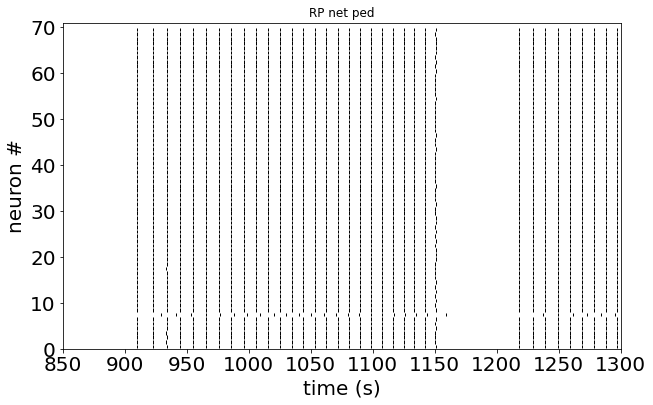

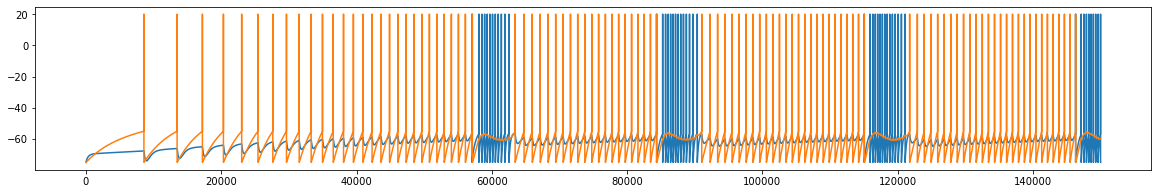

In [6]:
%matplotlib inline
sim_ped_reg(ntwk, zcut=.6, num_pm=17, conn_scale=.6)

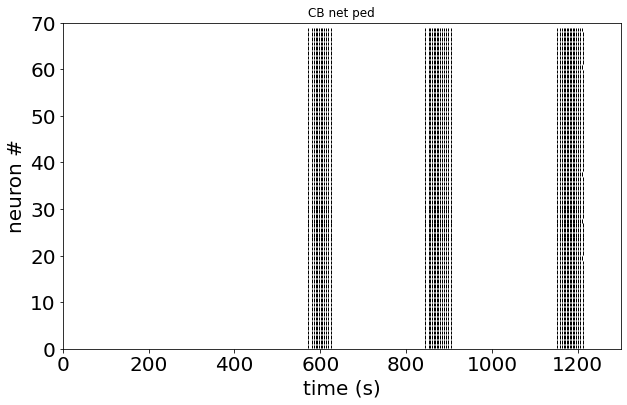

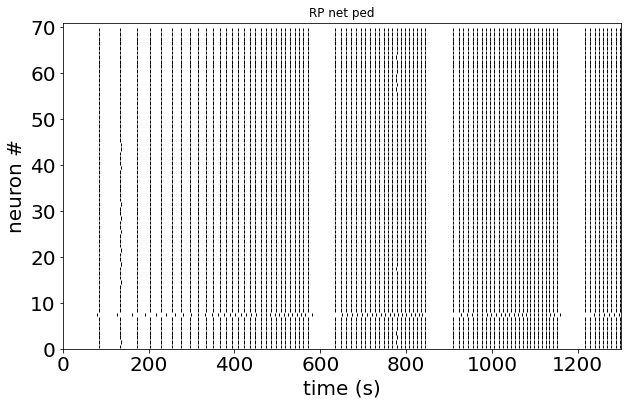

In [7]:
XMIN = 0
XMAX = 1300
ZCUT = .6

# select neurons to plot
indices_cb_ped = []
indices_cb_hyp = []
for i in range(ntwk.cbnet.num):
    if ntwk.cbnet.locations[i][1] < ZCUT:
        indices_cb_ped.append(i)
    else:
        indices_cb_hyp.append(i)

indices_rp_ped = []
indices_rp_hyp = []
for i in range(ntwk.rpnet.num):
    if ntwk.rpnet.locations[i][1] < ZCUT:
        indices_rp_ped.append(i)
    else:
        indices_rp_hyp.append(i)

# ntwk.cbnet.disp(xlim=(350, 800), title='CB net hyp', indices=indices_cb_hyp)
# ntwk.rpnet.disp(xlim=(350, 800), title='RP net hyp', indices=indices_rp_hyp)
ntwk.cbnet.disp(xlim=(XMIN, XMAX), title='CB net ped', indices=indices_cb_ped)
ntwk.rpnet.disp(xlim=(XMIN, XMAX), title='RP net ped', indices=indices_rp_ped)

## .8

In [6]:
ntwk = CylEctoNetwork(tmax=1500,
                      num_cb=100,
                      num_rp=100,
                      num_hyp=30,
                      num_ped=30,
                      gc_cb=500,
                      gc_rp=500,
                      pm_cb=list(range(30)),
                      tau_inh_cb=5,
                      tau_inh_rp=5,
                      a_inh_cb=40,
                      a_inh_rp=40,
                      lambda_d=(.25, .25),
                      t_ref=.1,
                      seed_cb=123,
                      seed_rp=5)

# modify pacemakers
for pm in ntwk.cbnet.pacemakers:
    neuron = ntwk.cbnet.neurons[pm]
    neuron.k_a = 7500
    neuron.k_e = 1000

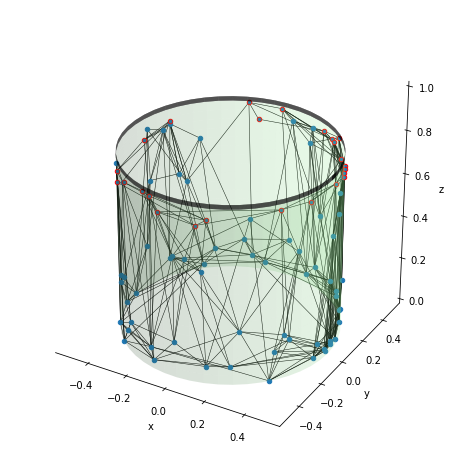

100%|████████████████████████████████████| 149999/149999 [08:25<00:00, 296.97it/s]


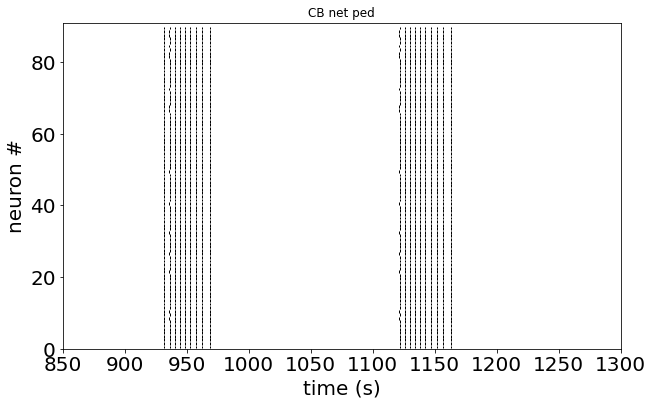

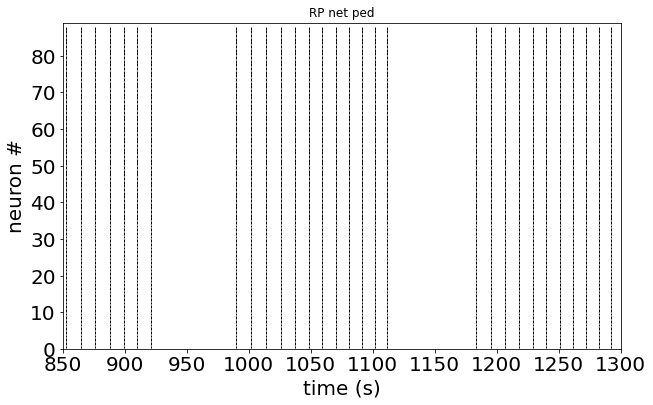

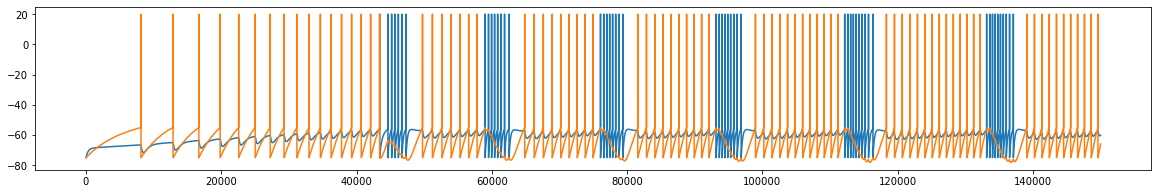

In [7]:
sim_ped_reg(ntwk, zcut=.8, num_pm=25, conn_scale=.8)

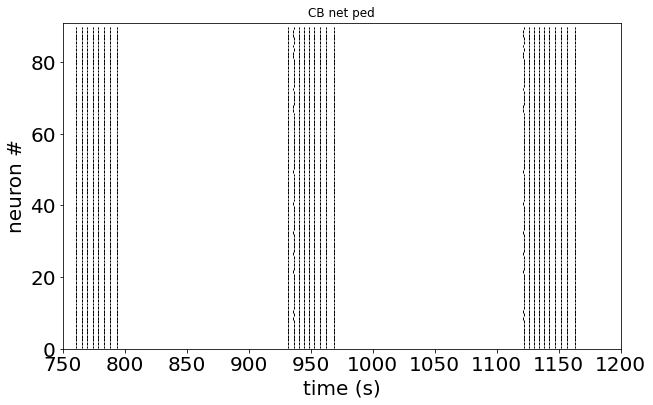

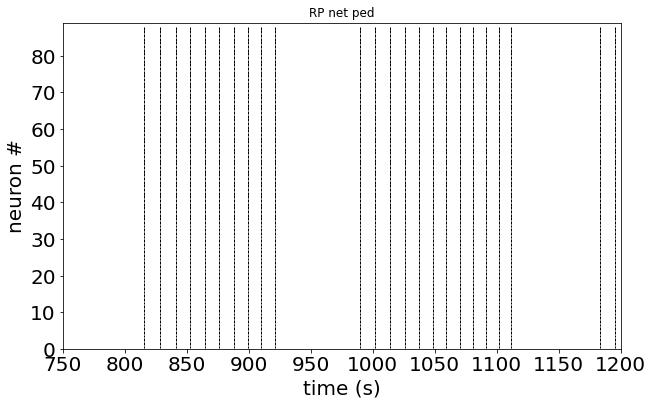

In [10]:
XMIN = 750
XMAX = 1200
ZCUT = .8

# select neurons to plot
indices_cb_ped = []
indices_cb_hyp = []
for i in range(ntwk.cbnet.num):
    if ntwk.cbnet.locations[i][1] < ZCUT:
        indices_cb_ped.append(i)
    else:
        indices_cb_hyp.append(i)

indices_rp_ped = []
indices_rp_hyp = []
for i in range(ntwk.rpnet.num):
    if ntwk.rpnet.locations[i][1] < ZCUT:
        indices_rp_ped.append(i)
    else:
        indices_rp_hyp.append(i)

# ntwk.cbnet.disp(xlim=(350, 800), title='CB net hyp', indices=indices_cb_hyp)
# ntwk.rpnet.disp(xlim=(350, 800), title='RP net hyp', indices=indices_rp_hyp)
ntwk.cbnet.disp(xlim=(XMIN, XMAX), title='CB net ped', indices=indices_cb_ped)
ntwk.rpnet.disp(xlim=(XMIN, XMAX), title='RP net ped', indices=indices_rp_ped)